# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a TensorFlow version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.TFViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.TFSwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.TFConvNextForImageClassification)
* [RegNet](https://huggingface.co/docs/transformers/master/en/model_doc/regnet#transformers.TFRegNetForImageClassification)
* [ResNet](https://huggingface.co/docs/transformers/master/en/model_doc/resnet#transformers.TFResNetForImageClassification)

- in short, any model supported by [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.TFAutoModelForImageClassification).

## Data augmentation

This notebook leverages TensorFlow's [image](https://www.tensorflow.org/api_docs/python/tf/image) module for applying data augmentation. Alternative notebooks which leverage other libraries such as [Albumentations](https://albumentations.ai/) to come!

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

In [37]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune


# reducing batch size to fit 36 GB cluster 
# batch_size = 32 # batch size for training and evaluation

batch_size = 2  # batch size for training and evaluation

Before we start, let's install the `datasets` and `transformers` libraries.

In [2]:
!pip install -q datasets transformers

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [38]:
%%capture
!git lfs install
!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [39]:
from transformers.utils import send_example_telemetry

# send_example_telemetry("image_classification_notebook", framework="tensorflow")

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument. 

In [40]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)

#This does not work directly , the only waythis will work , is by downloading the images locally and reference the folder.

# dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")



dataset = load_dataset("imagefolder", data_files="/home/geo/code/image-data/EuroSAT.zip")

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)
# dataset = load_dataset("nielsr/eurosat")

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
# dataset = load_dataset("cifar10")

In [41]:
!pip install scikit-learn

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [42]:
from datasets import load_metric


metric = load_metric("accuracy")

/home/geo/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [43]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [44]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [45]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

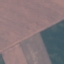

In [46]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

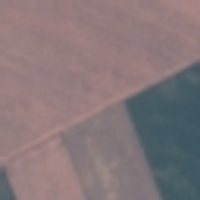

In [47]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [48]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [49]:
dataset["train"].features["label"]

ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [50]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[5]

'Pasture'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `tf.image` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [51]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/home/geo/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [52]:
feature_extractor.size.get("height")
feature_extractor.size.get("width")

224

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using `.map()` or `.set_transform()`).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [53]:
import numpy as np
import tensorflow as tf
from keras import backend


def normalize_img(img, mean, std):
    mean = tf.constant(mean)
    std = tf.constant(std)
    return (img - mean) / tf.maximum(std, backend.epsilon())


def get_resize_shape(img, size):
    if isinstance(size, tuple):
        return size
    

    
    # this code will not get : ::: height, width, _ = img.shape.size
    height, width, _ = img.shape
    
    
    
    target_height = int(size * height / width) if height > width else size
    target_width = int(size * width / height) if width > height else size    
    return (target_height, target_width)


def get_random_crop_size(img, scale=(0.08, 1.0), ratio=(3/4, 4/3)):
    height, width, channels = img.shape
    img_ratio = width / height
    crop_log_ratio = np.random.uniform(*np.log(ratio), size=1)
    crop_ratio = np.exp(crop_log_ratio)
    crop_scale = np.random.uniform(*scale, size=1)
    
    # Make sure the longest side is within the image size
    if crop_ratio < img_ratio:
        crop_height = int(height * crop_scale)
        crop_width = int(crop_height * crop_ratio)
    else:
        crop_width = int(width * crop_scale)
        crop_height = int(crop_width / crop_ratio)
    return (crop_height, crop_width, channels)


def train_transforms(image):
    image = tf.keras.utils.img_to_array(image) 
    # Note - this augmentation isn't exactly the same in the PyTorch 
    # examples in:
    # https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb
    # as there isn't a direct RandomResizedCrop equivalent. 
    # A custom transform would need to be implemented for this. 
    
    # Randomly select the crop size based on a possible scale 
    # and ratio range
    crop_size = get_random_crop_size(image)
    image = tf.image.random_crop(image, size=crop_size)
    image = tf.image.resize(
        image, 
        size=(feature_extractor.size.get("height"), feature_extractor.size.get("width")), 
        method=tf.image.ResizeMethod.BILINEAR
    )
    image = tf.image.random_flip_left_right(image)
    image /= 255
    image = normalize_img(
        image, 
        mean=feature_extractor.image_mean, 
        std=feature_extractor.image_std
    )
    # All image models take channels first format: BCHW
    image = tf.transpose(image, (2, 0, 1))
    return image


def val_transforms(image):
    image = tf.keras.utils.img_to_array(image) 
    # bug
    #resize_shape = get_resize_shape(image, feature_extractor.size)
    
    resize_shape = [feature_extractor.size.get("height") ,feature_extractor.size.get("width")]
    
    image = tf.image.resize(
        image, 
        size=resize_shape, 
        method=tf.image.ResizeMethod.BILINEAR
    )
    image = tf.image.crop_to_bounding_box(
        image, 
        # offset_height=image.shape[0] // 2 - feature_extractor.size // 2,
        # offset_width=image.shape[1] // 2 - feature_extractor.size // 2,

        offset_height=image.shape[0] // 2 - feature_extractor.size.get("height") // 2,
        offset_width=image.shape[1] // 2 - feature_extractor.size.get("width") // 2,
        

    
        # target_height=feature_extractor.size,
        # target_width=feature_extractor.size,

        target_height=feature_extractor.size.get("height"),
        target_width=feature_extractor.size.get("width"),
    )
    image /= 255
    image = normalize_img(
        image, 
        mean=feature_extractor.image_mean, 
        std=feature_extractor.image_std
    )
    # All image models take channels first format: BCHW
    image = tf.transpose(image, (2, 0, 1))
    return image


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch['pixel_values'] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch['pixel_values'] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

Let's quickly visualise some example outputs from our processing pipeline. 

Part of the processing pipeline rescales them between [0, 1] and normalizes them. This results in pixel values having negative values. To easily visualise and compare the original images and augmentations we undo this normalization and rescaling here.

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(crop_width / crop_ratio)
/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a sc

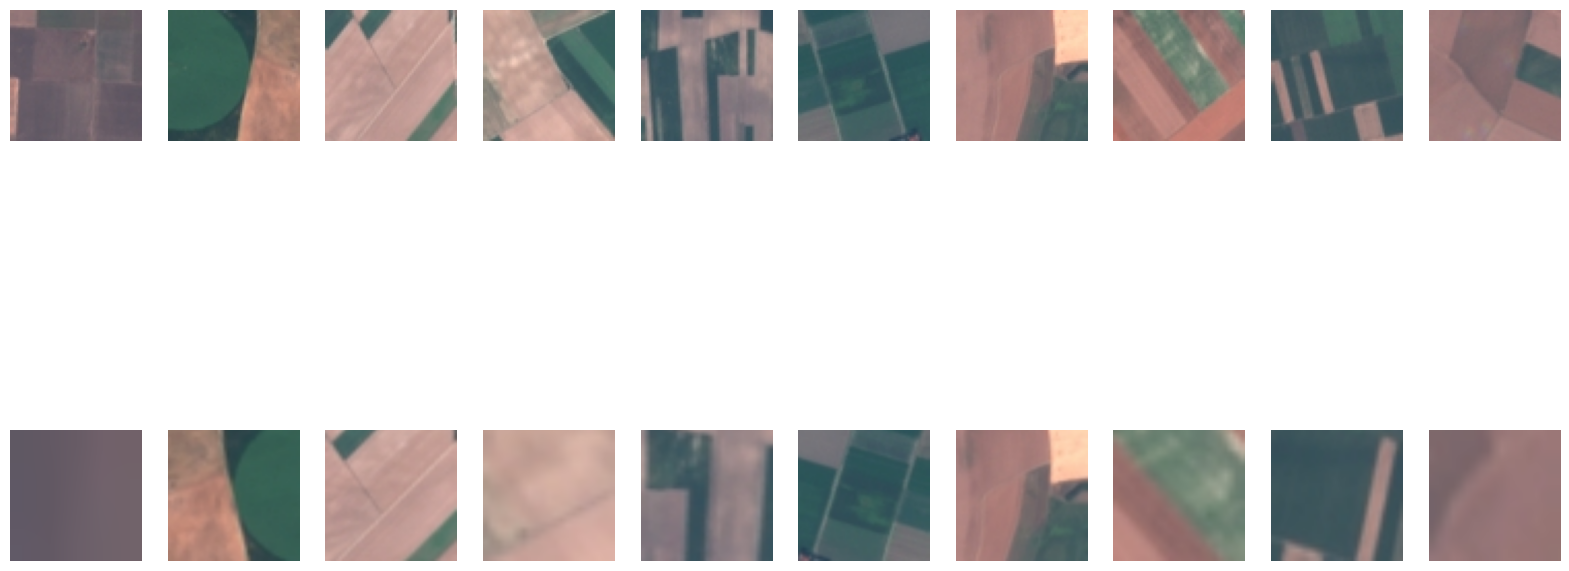

In [55]:
def unnormalize_img(img, mean, std):
    img = (img * std) + mean
    return img


def process_for_plotting(img):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    img = unnormalize_img(
        img=img,
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
    img = img * 255
    img = img.astype(int)
    return img


n = 10
fig, ax = plt.subplots(2, n, figsize=(20, 10))


for i in range(n):
    orig_img = dataset['train'][i]['image']
    proc_img = train_transforms(orig_img)
    
    orig_img = np.array(orig_img.convert("RGB"))
    # In order to plot and easy compare the images, 
    # we denormalise and rescale here so that pixel values
    # are between [0, 255] and reorder to be HWC
    proc_img = process_for_plotting(proc_img)
    
    ax[0][i].imshow(orig_img)
    ax[1][i].imshow(proc_img)
    ax[0][i].axis('off')
    ax[1][i].axis('off')

In [56]:

'''
The following error will happen if you do not correct the size declaration into height and width separately

/tmp/ipykernel_2192/232302907.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_2192/232302907.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(crop_height * crop_ratio)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[31], line 25
     23 for i in range(n):
     24     orig_img = dataset['train'][i]['image']
---> 25     proc_img = train_transforms(orig_img)
     27     orig_img = np.array(orig_img.convert("RGB"))
     28     # In order to plot and easy compare the images, 
     29     # we denormalise and rescale here so that pixel values
     30     # are between [0, 255] and reorder to be HWC

Cell In[29], line 55, in train_transforms(image)
     53 crop_size = get_random_crop_size(image)
     54 image = tf.image.random_crop(image, size=crop_size)
---> 55 image = tf.image.resize(
     56     image, 
     57     size=(feature_extractor.size, feature_extractor.size), 
     58     method=tf.image.ResizeMethod.BILINEAR
     59 )
     60 image = tf.image.random_flip_left_right(image)
     61 image /= 255

File ~/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py:153, in filter_traceback.<locals>.error_handler(*args, **kwargs)
    151 except Exception as e:
    152   filtered_tb = _process_traceback_frames(e.__traceback__)
--> 153   raise e.with_traceback(filtered_tb) from None
    154 finally:
    155   del filtered_tb

File ~/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/tensorflow/python/ops/image_ops_impl.py:1474, in _resize_images_common(images, resizer_fn, size, preserve_aspect_ratio, name, skip_resize_if_same)
   1472   size = ops.convert_to_tensor(size, dtypes.int32, name='size')
   1473 except (TypeError, ValueError):
-> 1474   raise ValueError('\'size\' must be a 1-D int32 Tensor')
   1475 if not size.get_shape().is_compatible_with([2]):
   1476   raise ValueError('\'size\' must be a 1-D Tensor of 2 elements: '
   1477                    'new_height, new_width')

ValueError: 'size' must be a 1-D int32 Tensor
'''

'\nThe following error will happen if you do not correct the size declaration into height and width separately\n\n/tmp/ipykernel_2192/232302907.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)\n  crop_height = int(height * crop_scale)\n/tmp/ipykernel_2192/232302907.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)\n  crop_width = int(crop_height * crop_ratio)\n\n---------------------------------------------------------------------------\nValueError                                Traceback (most recent call last)\nCell In[31], line 25\n     23 for i in range(n):\n     24     orig_img = dataset[\'train\'][i][\'image\']\n---> 25     proc_

Next, we can preprocess our dataset by applying these functions. We will use the set_transform functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [57]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [58]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [59]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 24300
})

Let's access an element to see that we've added a "pixel_values" feature:

In [60]:
train_ds[0]

/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(crop_height * crop_ratio)


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 6,
 'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[ 1.3070468 ,  1.3070468 ,  1.3070468 , ...,  1.6152923 ,
           1.6152923 ,  1.6152923 ],
         [ 1.3070468 ,  1.3070468 ,  1.3070468 , ...,  1.6152923 ,
           1.6152923 ,  1.6152923 ],
         [ 1.3070468 ,  1.3070468 ,  1.3070468 , ...,  1.6152923 ,
           1.6152923 ,  1.6152923 ],
         ...,
         [-0.09718303, -0.09718303, -0.09718303, ...,  0.27956167,
           0.27956167,  0.27956167],
         [-0.09718303, -0.09718303, -0.09718303, ...,  0.27956167,
           0.27956167,  0.27956167],
         [-0.09718303, -0.09718303, -0.09718303, ...,  0.27956167,
           0.27956167,  0.27956167]],
 
        [[ 0.41526622,  0.41526622,  0.41526622, ...,  0.69537824,
           0.69537824,  0.69537824],
         [ 0.41526622,  0.41526622,  0.41526622, ...,  0.69537824,
           0.69537824,  0.6953

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `TFAutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [61]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFSwinForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSwinForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.
Some weights of TFSwinForImageClassification were not initialized from the model checkpoint are newly init

The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [62]:
learning_rate = 5e-5
weight_decay = 0.01
epochs = 3

Now we initialize our optimizer.

In [63]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

Note that most models on the Hub compute loss internally, so we actually don't have to specify anything there! Leaving the loss field blank will cause the model to read the loss head as its loss value.

This is an unusual quirk of TensorFlow models in 🤗 Transformers, so it's worth elaborating on in a little more detail. All 🤗 Transformers models are capable of computing an appropriate loss for their task internally (for example, a CausalLM model will use a cross-entropy loss). To do this, the labels must be provided in the input dict (or equivalently, in the `columns` argument to `to_tf_dataset()`), so that they are visible to the model during the forward pass.

This is quite different from the standard Keras way of handling losses, where labels are passed separately and not visible to the main body of the model, and loss is handled by a function that the user passes to `compile()`, which uses the model outputs and the label to compute a loss value.

The approach we take is that if the user does not pass a loss to `compile()`, the model will assume you want the **internal** loss. If you are doing this, you should make sure that the labels column(s) are included in the **input dict** or in the `columns` argument to `to_tf_dataset`.

If you want to use your own loss, that is of course possible too! If you do this, you should make sure your labels column(s) are passed like normal labels, either as the **second argument** to model.fit(), or in the `label_cols` argument to `to_tf_dataset`.

In [64]:
model.compile(optimizer=optimizer)

We need to convert our datasets to a format Keras understands. The easiest way to do this is with the `to_tf_dataset()` method. Note that our data collators are designed to work for multiple frameworks, so ensure you set the `return_tensors='np'` argument to get NumPy arrays out - you don't want to accidentally get a load of `torch.Tensor` objects in the middle of your nice TF code! You could also use `return_tensors='tf'` to get TensorFlow tensors, but our `to_tf_dataset` pipeline actually uses a NumPy loader internally, which is wrapped at the end with a `tf.data.Dataset`. As a result, `np` is usually more reliable and performant when you're using it!

In [65]:
# describe model 

In [66]:
model.summary()

Model: "tf_swin_for_image_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 swin (TFSwinMainLayer)      multiple                  27548166  
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 27555856 (105.12 MB)
Trainable params: 27527044 (105.01 MB)
Non-trainable params: 28812 (112.55 KB)
_________________________________________________________________


In [67]:
from transformers import DefaultDataCollator

In [68]:
data_collator = DefaultDataCollator(return_tensors="np")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(crop_height * crop_ratio)
/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a sc

`train_set` is now a `tf.data.Dataset` type object. We see that it contains two elements - `labels` and `pixel_values` (but not `image`) as a result of the preprocessing done in `preprocess_train`. 

In [69]:
train_set

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None)}>

In [70]:
batch = next(iter(train_set))
batch

/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(crop_width / crop_ratio)


{'labels': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 4])>,
 'pixel_values': <tf.Tensor: shape=(2, 3, 224, 224), dtype=float32, numpy=
 array([[[[ 0.33093593,  0.33093593,  0.33093593, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ],
          [ 0.33093593,  0.33093593,  0.33093593, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ],
          [ 0.33093593,  0.33093593,  0.33093593, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ],
          ...,
          [ 0.43368444,  0.43368444,  0.43368444, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ],
          [ 0.43368444,  0.43368444,  0.43368444, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ],
          [ 0.43368444,  0.43368444,  0.43368444, ...,  0.2281874 ,
            0.2281874 ,  0.2281874 ]],
 
         [[ 0.11764706,  0.11764706,  0.11764706, ...,  0.11764706,
            0.11764706,  0.11764706],
          [ 0.11764706,  0.11764706,  0.11764706, ...,  0.11764706,
            0.11764706,  0.

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits.

In addition, let's wrap this metric computation function in a `KerasMetricCallback`. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

Why do it this way, though, and not just use a straightforward Keras Metric object? This is a good question - on this task, metrics such as Accuracy are very straightforward, and it would probably make more sense to just use a Keras metric for those instead. However, we want to demonstrate the use of `KerasMetricCallback` here, because it can handle any arbitrary Python function for the metric computation. 

Wow do we actually use `KerasMetricCallback`? We simply define a function that computes metrics given a tuple of numpy arrays of predictions and labels, then we pass that, along with the validation set to compute metrics on, to the callback:

In [71]:
import numpy as np
from transformers.keras_callbacks import KerasMetricCallback

# the compute_metrics function takes a Tuple as input:
# first element is the logits of the model as Numpy arrays,
# second element is the ground-truth labels as Numpy arrays.
def compute_metrics(eval_predictions):
    predictions = np.argmax(eval_predictions[0], axis=1)
    metric_val = metric.compute(predictions=predictions, references=eval_predictions[1])
    return {"val_" + k: v for k, v in metric_val.items()}

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=val_set, batch_size=batch_size, label_cols=['labels']
)

Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [72]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./ic_from_scratch_model_save/logs")

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-eurosat"

push_to_hub_callback = PushToHubCallback(
    output_dir="./ic_from_scratch_model_save",
    hub_model_id=push_to_hub_model_id,
    tokenizer=feature_extractor
)

/home/geo/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/geo/code/hugging-face-notebooks/examples/ic_from_scratch_model_save is already a clone of https://huggingface.co/ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat. Make sure you pull the latest changes with `repo.git_pull()`.


In [73]:
callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback] 

In [74]:
model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/3


/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(crop_height * crop_ratio)
/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a sc

12150/12150 [==============================] - 857s 69ms/step - loss: 0.7934 - val_loss: 0.2019 - val_accuracy: 0.9333
Epoch 2/3
    2/12150 [..............................] - ETA: 15:01 - loss: 0.9435

/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(crop_width / crop_ratio)
/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a sc

12150/12150 [==============================] - 819s 67ms/step - loss: 0.5631 - val_loss: 0.2128 - val_accuracy: 0.9307
Epoch 3/3
    2/12150 [..............................] - ETA: 14:02 - loss: 0.3159

/tmp/ipykernel_5655/154879863.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_width = int(width * crop_scale)
/tmp/ipykernel_5655/154879863.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(crop_width / crop_ratio)
/tmp/ipykernel_5655/154879863.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crop_height = int(height * crop_scale)
/tmp/ipykernel_5655/154879863.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a sc

12150/12150 [==============================] - 820s 67ms/step - loss: 0.5115 - val_loss: 0.1813 - val_accuracy: 0.9437


Once the training is completed, we can evaluate our model and get its loss on the validation set like this:

In [76]:
eval_loss = model.evaluate(val_set)
eval_loss

1350/1350 [==============================] - 33s 24ms/step - loss: 0.1813


0.1813231110572815

Alternatively, we could also get the predictions from the model, and calculate metrics using the `datasets.Metric` object. 

In [77]:
for batch in iter(val_set):
    predictions = model.predict(batch)
    predicted_labels = np.argmax(predictions.logits, -1)
    metric.add_batch(predictions=predicted_labels, references=batch['labels'])

metric.compute()

1/1 [==============================] - 0s 44ms/step


{'accuracy': 0.9437037037037037}

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = TFAutoFeatureExtractor.from_pretrained("amyeroberts/my-awesome-model")
model = TFAutoModelForImageClassification.from_pretrained("amyeroberts/my-awesome-model")

```

In [80]:
from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat")
model = TFAutoModelForImageClassification.from_pretrained("ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat")


preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

/home/geo/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/111M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSwinForImageClassification.

All the layers of TFSwinForImageClassification were initialized from the model checkpoint at ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a forest (that's not part of the EuroSAT dataset), and see how the model does.

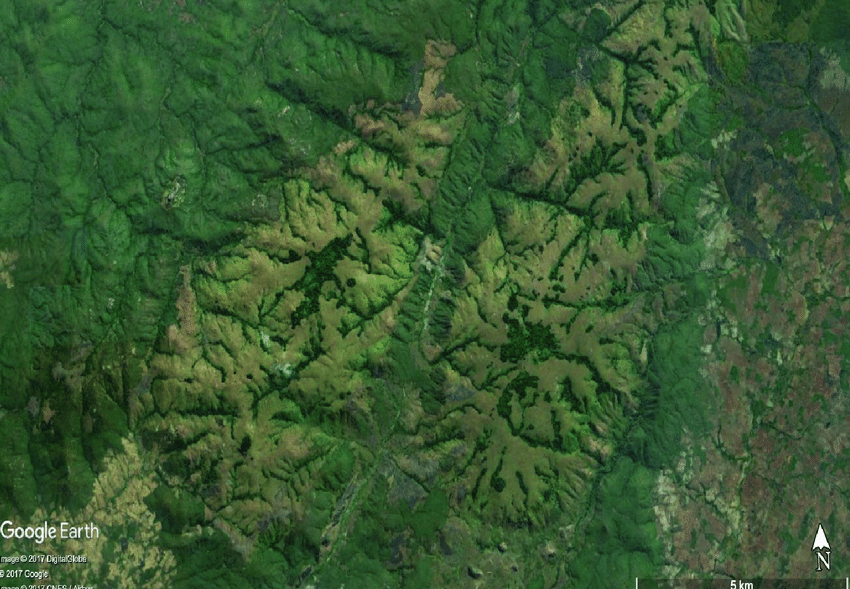

In [81]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [82]:
from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor

# repo_name = "amyeroberts/swin-tiny-patch4-window7-224-finetuned-eurosat"
repo_name = "ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = TFAutoModelForImageClassification.from_pretrained(repo_name)

All model checkpoint layers were used when initializing TFSwinForImageClassification.

All the layers of TFSwinForImageClassification were initialized from the model checkpoint at ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


In [83]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="tf")
print(encoding.pixel_values.shape)

(1, 3, 224, 224)


In [84]:
outputs = model(encoding)
logits = outputs.logits

In [85]:
predicted_class_idx = tf.math.argmax(logits, -1).numpy()[0]
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Forest


Looks like our model got it correct!

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Note the configuration for `feature_extractor` will be pulled from the specified repo and used to build the `feature_extractor` in this pipeline.

Let's showcase this for our trained model:

In [87]:
from transformers import pipeline

# pipe = pipeline(
#     "image-classification", 
#     "amyeroberts/swin-tiny-patch4-window7-224-finetuned-eurosat",
#     framework="tf"
# )

pipe = pipeline(
    "image-classification", 
    repo_name,
    framework="tf"
)

All model checkpoint layers were used when initializing TFSwinForImageClassification.

All the layers of TFSwinForImageClassification were initialized from the model checkpoint at ggergues/swin-tiny-patch4-window7-224-finetuned-eurosat.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.
/home/geo/anaconda3/envs/tf-opencv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [88]:
pipe.feature_extractor

In [89]:
pipe(image)

[{'score': 0.9598407745361328, 'label': 'Forest'},
 {'score': 0.03532163426280022, 'label': 'Residential'},
 {'score': 0.004194965120404959, 'label': 'HerbaceousVegetation'},
 {'score': 0.00025877024745568633, 'label': 'Highway'},
 {'score': 0.0001253869413631037, 'label': 'PermanentCrop'}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and feature extractors:

In [90]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=feature_extractor)

In [91]:
pipe(image)

[{'score': 0.9598407745361328, 'label': 'Forest'},
 {'score': 0.03532163426280022, 'label': 'Residential'},
 {'score': 0.004194965120404959, 'label': 'HerbaceousVegetation'},
 {'score': 0.00025877024745568633, 'label': 'Highway'},
 {'score': 0.0001253869413631037, 'label': 'PermanentCrop'}]